# Feature 5 : Player performance

In [1]:
from urllib.parse import unquote
import numpy as np
import pandas as pd
from pathlib import Path
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns

In [12]:
### Loading the data ###
PATH = Path.cwd()
PATH = PATH.parent
DATA_PATH = PATH / "data/wikispeedia_paths-and-graph/"
shortest_path = (DATA_PATH / "shortest-path-distance-matrix.txt").resolve()
PATHS_FINISHED = (DATA_PATH / "paths_finished.tsv").resolve()
PATHS_UNFINISHED = (DATA_PATH / "paths_unfinished.tsv").resolve()

assert shortest_path.is_file()
shortest_path = np.loadtxt(shortest_path, dtype=str)

links_path = (DATA_PATH / "links.tsv").resolve()
assert links_path.is_file()
links = pd.read_csv(
    links_path,
    sep="\t",
    header=None,
    names=["from", "to"],
    skiprows=11,
    skip_blank_lines=True,
)

articles_path = (DATA_PATH / "articles.tsv").resolve()
assert articles_path.is_file()
articles = pd.read_csv(
    articles_path,
    sep="\t",
    header=None,
    names=["name"],
    skiprows=11,
    skip_blank_lines=True,
)


def convert_to_matrix(data):
    """Replaces each row (string) with the integer values of the string and replaces _ with NaN"""
    data = np.array([[int(i) if i != "_" else np.nan for i in row] for row in data])
    return data


def parse_paths(dataframe):
    """Parses the path column into a list of strings"""
    dataframe["path"] = dataframe["path"].map(lambda x: x.split(";"))
    return dataframe


shortest_path_matrix = convert_to_matrix(shortest_path)


def compare_paths(user_path):
    """Looks up for the optimal path and compares it to the user path."""
    start, end = user_path[0], user_path[-1]
    try:
        shortest_p = shortest_path_df.loc[start, end]
        if shortest_p == 0:
            shortest_p = 1  # FIXME
        elif np.isnan(shortest_p):
            return np.nan
    except KeyError:
        return np.nan
    user_len = len(user_path)
    if np.isnan(shortest_p):
        return np.nan
    return user_len / shortest_p


def average_ratio(dataframe):
    """Calculates the average ratio for each player"""
    dataframe = dataframe.groupby("hashedIpAddress").agg(
        {
            "ratio": "mean",
            "path": "count",
            "durationInSec": "mean",
            "average_time_on_page": "mean",
        }
    )
    dataframe = dataframe.rename(columns={"path": "count"})
    dataframe = dataframe.rename(columns={"durationInSec": "mean_duration"})
    return dataframe


def player_unfinished(dataframe):
    """Calculates the number of unfinished paths and giving up time average for each player"""
    dataframe = dataframe.groupby("hashedIpAddress").agg(
        {"path": "count", "durationInSec": "mean"}
    )
    dataframe = dataframe.rename(columns={"path": "count"})
    dataframe = dataframe.rename(columns={"durationInSec": "mean_duration"})
    return dataframe



## Data exploration

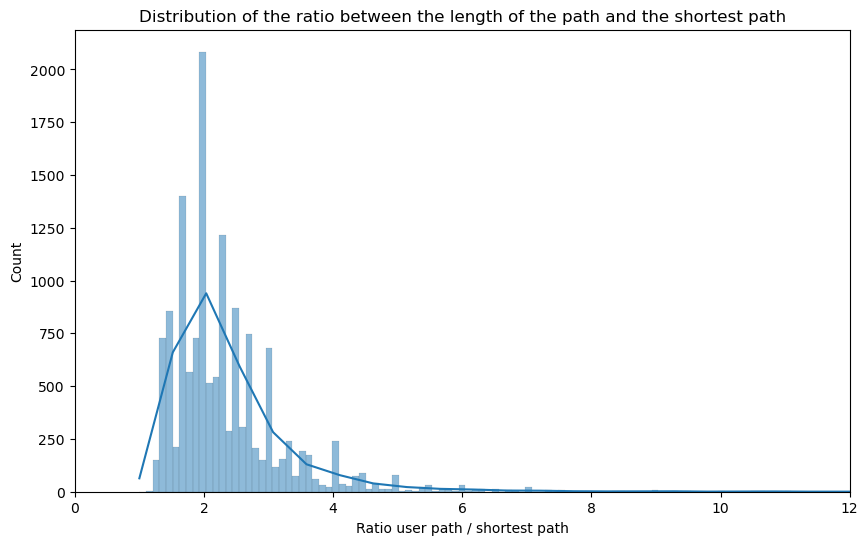

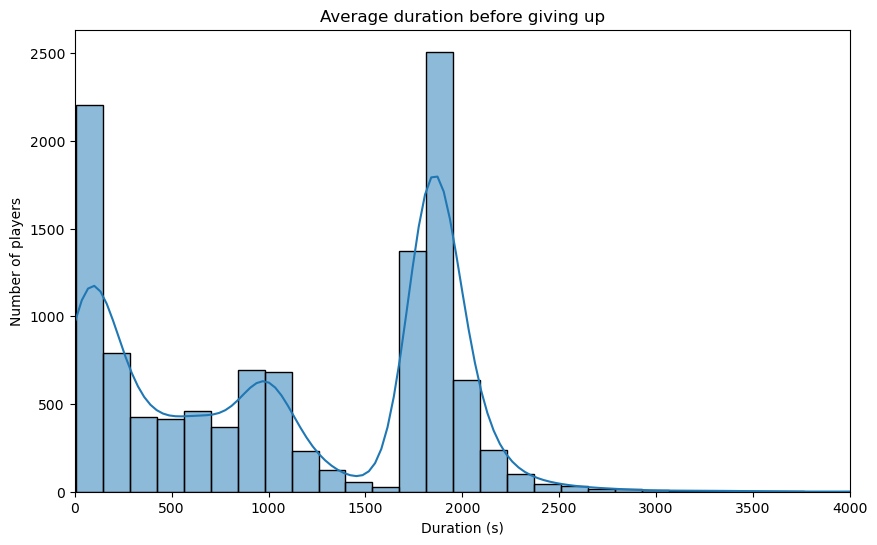

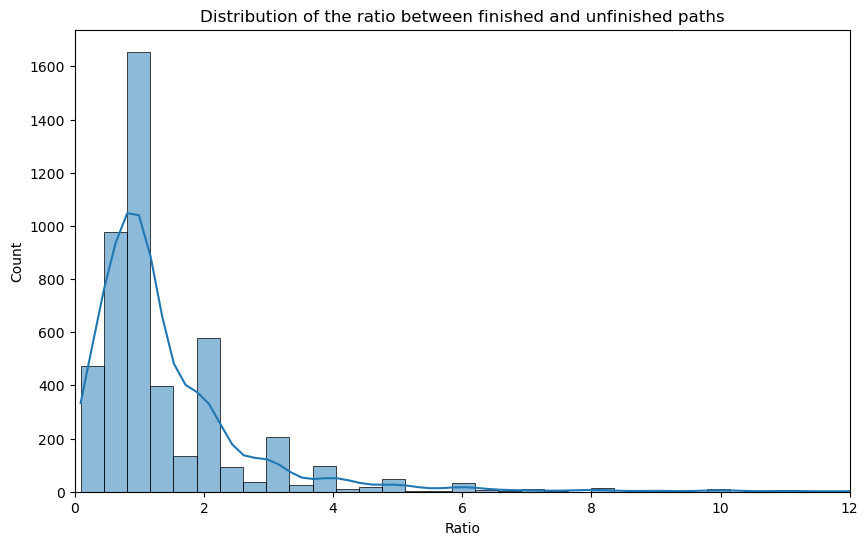

In [13]:

### Data Exploration ###
paths_finished = pd.read_csv(
    PATHS_FINISHED,
    sep="\t",
    header=None,
    names=["hashedIpAddress", "timestamp", "durationInSec", "path", "rating"],
    encoding="utf-8",
    skiprows=16,
).copy(deep=True)
paths_finished["timestamp"] = pd.to_datetime(paths_finished["timestamp"], unit="s")
paths_finished = parse_paths(paths_finished)
paths_finished["path"] = paths_finished["path"].apply(lambda x: [unquote(i) for i in x])

paths_unfinished = pd.read_csv(
    PATHS_UNFINISHED,
    sep="\t",
    header=None,
    names=["hashedIpAddress", "timestamp", "durationInSec", "path", "target", "type"],
    encoding="utf-8",
    skiprows=17,
).copy(deep=True)
paths_unfinished["timestamp"] = pd.to_datetime(paths_unfinished["timestamp"], unit="s")
paths_unfinished = parse_paths(paths_unfinished)
paths_unfinished["path"] = paths_unfinished["path"].apply(
    lambda x: [unquote(i) for i in x]
)

# Unquote article names
articles.name = articles.name.apply(unquote)
# Add a column for each article name, and fill the dataframe with shortest path distances
shortest_path_df = pd.DataFrame(
    shortest_path_matrix, index=articles.name, columns=articles.name
)

# For each player, calculate the ratio between the length of the path and the shortest path
paths_finished = paths_finished.copy(deep=True)
paths_finished["ratio"] = paths_finished["path"].apply(compare_paths)
paths_finished["path_len"] = paths_finished["path"].apply(len)
paths_finished["average_time_on_page"] = (
    paths_finished["durationInSec"] / paths_finished["path_len"]
)

players_finished = average_ratio(paths_finished)
players_unfinished = player_unfinished(paths_unfinished.copy(deep=True))

# Merge the two dataframes
players = players_finished.merge(
    players_unfinished, how="outer", left_index=True, right_index=True
)
players = players.rename(
    columns={"count_x": "count_finished", "count_y": "count_unfinished"}
)
players = players.rename(
    columns={
        "mean_duration_x": "mean_duration_finished",
        "mean_duration_y": "mean_duration_unfinished",
    }
)

finished_unfinished = players[["count_finished", "count_unfinished"]].copy(deep=True)
finished_unfinished = finished_unfinished.dropna()

### Plots ###

# Plot the distribution of the ratio
plt.figure(figsize=(10, 6))
sns.histplot(data=players, x="ratio", bins=1000, kde=True)
plt.title("Distribution of the ratio between the length of the path and the shortest path")
plt.xlabel("Ratio user path / shortest path")
plt.xlim(0, 12)
plt.ylabel("Count")
plt.show()

# Histogram of the average duration before giving up
players_unfinished = players[players["count_unfinished"] > 0]

plt.figure(figsize=(10, 6))
sns.histplot(players_unfinished["mean_duration_unfinished"], kde=True)
plt.title("Average duration before giving up")
plt.xlabel("Duration (s)")
plt.xlim(0, 4000)
plt.ylabel("Number of players")
plt.show()

players_paths = players.copy(deep=True)
players_paths["ratio-f-u"] = (
    players_paths["count_finished"] / players_paths["count_unfinished"]
)

plt.figure(figsize=(10, 6))
sns.histplot(data=players_paths, x="ratio-f-u", bins=100, kde=True)
plt.title("Distribution of the ratio between finished and unfinished paths")
plt.xlabel("Ratio")
plt.xlim(0, 12)
plt.ylabel("Count")
plt.show()


**Distribtion of the ratio between the user path and the shortest path** \
The ratio between the user path and the shortest path is a good indicator of the user performance. The higher the ratio, the more the user is far from the shortest path. The lower the ratio, the more the user is close to the shortest path. We see that the majority of the users are near 2, showing that they are far from the shortest path. We also see that the distribution is not normal, a long tail on the right.

**Average duration before giving up** \
A lot of player give up at the begining, maybe because the difficulty of the path is too high, the other peak is at 30 minutes (1800 seconds), because of the server timeout.

**Ratio between finished path and unfinished path** \
This ratio allows for a good comparaison between players.


## Data Analysis

<Figure size 1000x600 with 0 Axes>

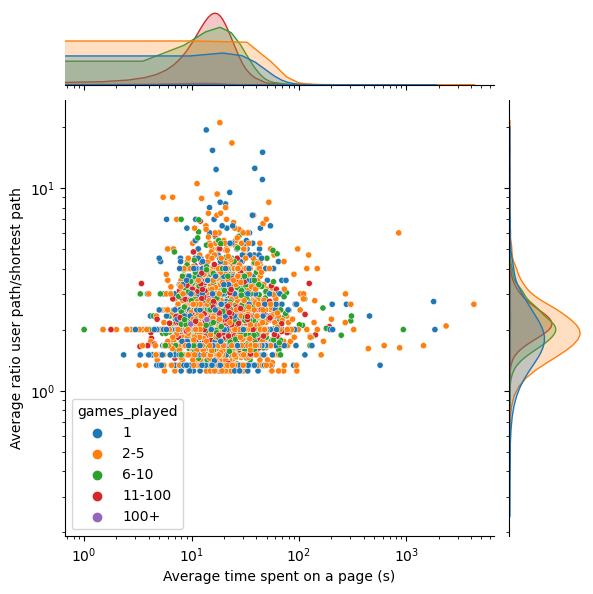

In [7]:
# Plot of a scatterplot of the average path ratio and the average time spent on a page, with the number of games played as the color of the points
players_games_played = players.copy(deep=True)
players_games_played["games_played"] = (
    players_games_played["count_finished"] + players_games_played["count_unfinished"]
)
players_games_played["games_played"] = pd.cut(
    players_games_played["games_played"],
    bins=[1, 2, 5, 10, 100, 10000],
    labels=["1", "2-5", "6-10", "11-100", "100+"],
)
plt.figure(figsize=(10, 6))
sns.jointplot(
    data=players_games_played,
    x="average_time_on_page",
    y="ratio",
    hue="games_played",
    s=20,
)
plt.xlabel("Average time spent on a page (s)")
plt.xscale("log")
plt.ylabel("Average ratio user path/shortest path")
plt.yscale("log")
plt.show()

**Average ratio user path / shortest path over average time on a page** \
This graph is a good qualitative indicator of path optimization over time. The lower the range of games played, the more variance the average user path seems to show. This is especially observable in the two extreme cases : 1 game played and 100+ games played. The 1 game played points are spread in a cross pattern while the 100+ games played data points are concentrated into what seems to be the optimized path. \
Therefore, We see that the ratio is decreasing over time, showing that the user is optimizing his path, therefore examplifying a learning component.

<Figure size 1000x600 with 0 Axes>

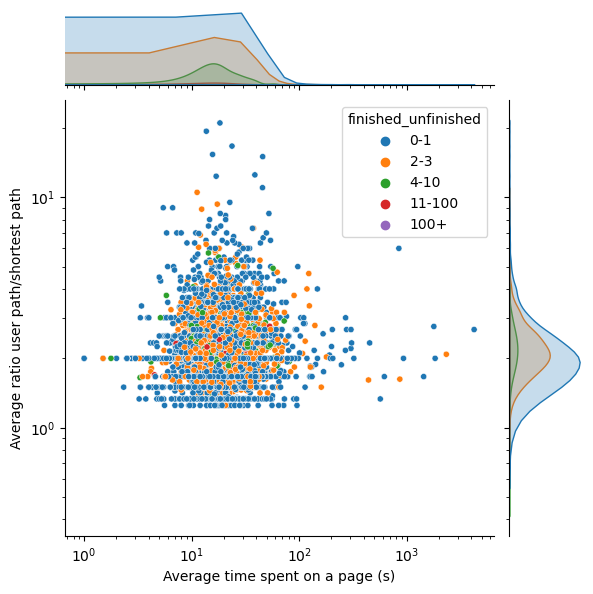

In [10]:
# Plot of a scatterplot of the average path ratio and the average time spent on a page, with the number of games played as the color of the points
players_finished_unfinished = players.copy(deep=True)
players_finished_unfinished["count_unfinished"] = players_finished_unfinished[
    "count_unfinished"
].dropna()
players_finished_unfinished["count_finished"] = players_finished_unfinished[
    "count_finished"
].dropna()
players_finished_unfinished["finished_unfinished"] = (
    players_finished_unfinished["count_finished"]
    / players_finished_unfinished["count_unfinished"]
)
players_finished_unfinished["finished_unfinished"] = pd.cut(
    players_finished_unfinished["finished_unfinished"],
    bins=[0, 1, 3, 10, 100, 10000],
    labels=["0-1", "2-3", "4-10", "11-100", "100+"],
)
plt.figure(figsize=(10, 6))
sns.jointplot(
    data=players_finished_unfinished,
    x="average_time_on_page",
    y="ratio",
    hue="finished_unfinished",
    s=20,
)
plt.xlabel("Average time spent on a page (s)")
plt.xscale("log")
plt.ylabel("Average ratio user path/shortest path")
plt.yscale("log")
plt.show()


**Average ratio user path / shortest path over average time on a page** \
This graph is a good qualitative indicator of path optimization over time. The lower finished unfinished ratio, the more variance the average user path seems to show.\
We see that the ratio is decreasing over time, showing that the user is optimizing his path, therefore examplifying a learning component.

<Figure size 1000x600 with 0 Axes>

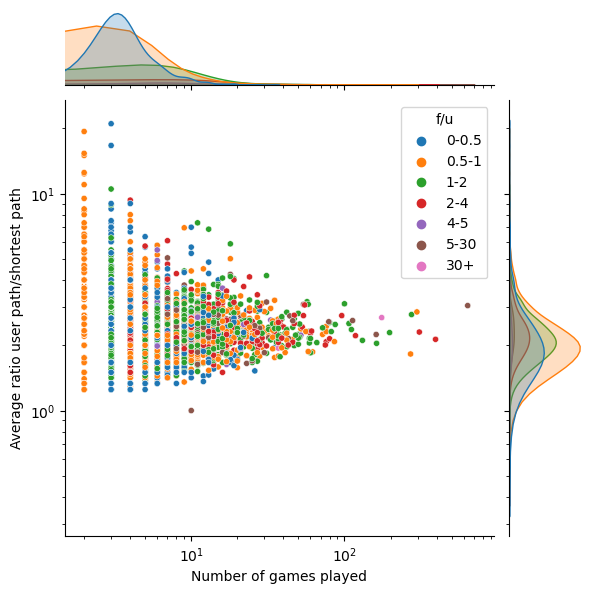

In [11]:
players_games_played = players.copy(deep=True)
players_games_played["games_played"] = (
    players_games_played["count_finished"] + players_games_played["count_unfinished"]
)
players_games_played["f/u"] = (
    players_games_played["count_finished"] / players_games_played["count_unfinished"]
)
players_games_played["f/u"] = pd.cut(
    players_games_played["f/u"],
    bins=[0, 0.5, 1, 2, 4, 5, 30, 10000],
    labels=["0-0.5", "0.5-1", "1-2", "2-4", "4-5", "5-30", "30+"],
)
players_games_played = players_games_played[players_games_played["games_played"] > 0]

plt.figure(figsize=(10, 6))
sns.jointplot(data=players_games_played, x="games_played", y="ratio", hue="f/u", s=20)
plt.xlabel("Number of games played")
plt.xscale("log")
plt.ylabel("Average ratio user path/shortest path")
plt.yscale("log")
plt.show()

**Average ratio user path / shortest path over number of games played**\
This graph is a good qualitative indicator of path optimization over time. The higher finished unfinished ratio, the lower variance the average user path / shortest path seems to be.\
We see that the ratio is decreasing with win rate, showing that the user is optimizing his path, therefore examplifying a learning component.

## Conclusion

The analysis of data through following metrics: win ratio (finished/unfinished), games played, average time on a page, average ratio user path / shortest path, tend to support our hypothesis that **performance is positively correlated to the number of games played and win rate**. In other words, the more iterations and efforts a player showcases, the more his performance at the game will increase.